In [1]:
import datetime
import backtrader as bt
import backtrader.indicators as bi
from backtrader.feeds import PandasData

# import backtest
import pandas as pd
import numpy as np
# import math
import matplotlib.pyplot as plt

from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo, Blackly

Loading BokehJS ...

In [2]:
from lutils.stock import LTdxHq

In [3]:
lt = LTdxHq()

In [4]:
code = '603636' # 510300 000032 300142 603636 600519 688567 600217

In [5]:
df = lt.get_k_data_daily(code) # , qfq=True)

In [6]:
# df['dd'] = df['amount'] / df['high'] - df['amount'] / df['low']
df['dd'] = np.abs(df['amount'] / df['high'] - df['amount'] / df['low'])
# df['dd'] = df.dd.diff

In [7]:
df = df['2021-01-01':]

In [8]:
df.index = pd.to_datetime(df.index)

In [9]:
df

,open,close,high,low,volume,amount,dd
date,,,,,,,
2021-01-04,9.18,9.29,9.30,9.09,4484555.0,41926596.0,104150.669648
2021-01-05,9.31,9.32,9.44,9.28,3896723.0,36895040.0,67385.739334
2021-01-06,9.26,9.16,9.30,9.11,3874385.0,36067080.0,80884.118834
2021-01-07,9.15,8.84,9.15,8.69,5851525.0,52623452.0,304436.201651
2021-01-08,8.80,8.91,9.12,8.65,4604155.0,41699760.0,248439.397627
...,...,...,...,...,...,...,...
2021-11-17,8.41,8.48,8.55,8.41,2699311.0,22875266.0,44538.140198
2021-11-18,8.67,8.47,8.73,8.45,4033795.0,34521184.0,131030.609542
2021-11-19,8.47,8.46,8.55,8.38,2283936.0,19305234.0,45805.102374


In [10]:
class PandasDataDd(PandasData):
    # Add a 'action' line to the inherited ones from the base class
    lines = ('dd',)
    
    # add the parameter to the parameters inherited from the base class
    params = (('dd', 7),)

In [14]:
class SmaCross(bt.Strategy):
    def __init__(self):
#         sma1 = bt.ind.SMA(period=5)
#         sma2 = bt.ind.SMA(period=7)
#         bt.indicators.RSI_EMA(self.dnames.hs1d.close, period=14)
        
#         print(self.dnames.d['dd'])
        self.sma1 = bt.indicators.SMA(self.dnames.d.dd, period=10, plot=False)
        self.sma2 = bt.indicators.SMA(self.dnames.d.dd, period=20, plot=False)
        
        self.crossover = bt.indicators.CrossOver(self.sma1, self.sma2)
        
#         sma1, sma2 = bt.indicators.SMA(period=10), bt.ind.SMA(period=30)
#         crossover = bt.ind.CrossOver(sma1, sma2)
#         self.signal_add(bt.SIGNAL_LONG, crossover)

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position
            
#         if not self.position:
        
#         print(self.data0.dd[0], self.sma1[0])

#         if not self.position:
#             if self.data0.dd[0] > self.sma1[0] * 2 and self.data0.dd[0] > self.sma2[0] * 1.5:
#                 self.buy()
            
#         elif self.crossover < 0:  # in the market & cross to the downside
#             self.close()  # close long position
            

In [15]:
cerebro = bt.Cerebro(oldtrades=True)

# feed = bt.feeds.PandasData(dataname=df, openinterest=None) #, compression=1, timeframe=bt.TimeFrame.Minutes)
# feed = PandasDataDd(dataname=df, openinterest=None) #, compression=1, timeframe=bt.TimeFrame.Minutes)
feed = PandasDataDd(dataname=df,
#                      open=0,
#                      high=1,
#                      low=2,
#                      close=3,
                     dd=6,)

cerebro.adddata(feed, name='d')
# cerebro.addanalyzer(bt.analyzers.SharpeRatio)
cerebro.addstrategy(SmaCross)

cerebro.broker.setcash(10000.0)

cerebro.broker.setcommission(0.0005)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

result = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 9998.19


In [16]:
b = Bokeh() #plot_mode='tabs') #style='bar',  , scheme=Tradimo()
b = Bokeh(style='bar', tabs='multi', scheme=Tradimo(barup='red', bardown='green')) # , toolbar_location='right')
cerebro.plot(b)

[[<backtrader_plotting.bokeh.bokeh.FigurePage at 0x12c99dada08>]]

<IPython.core.display.Javascript object>


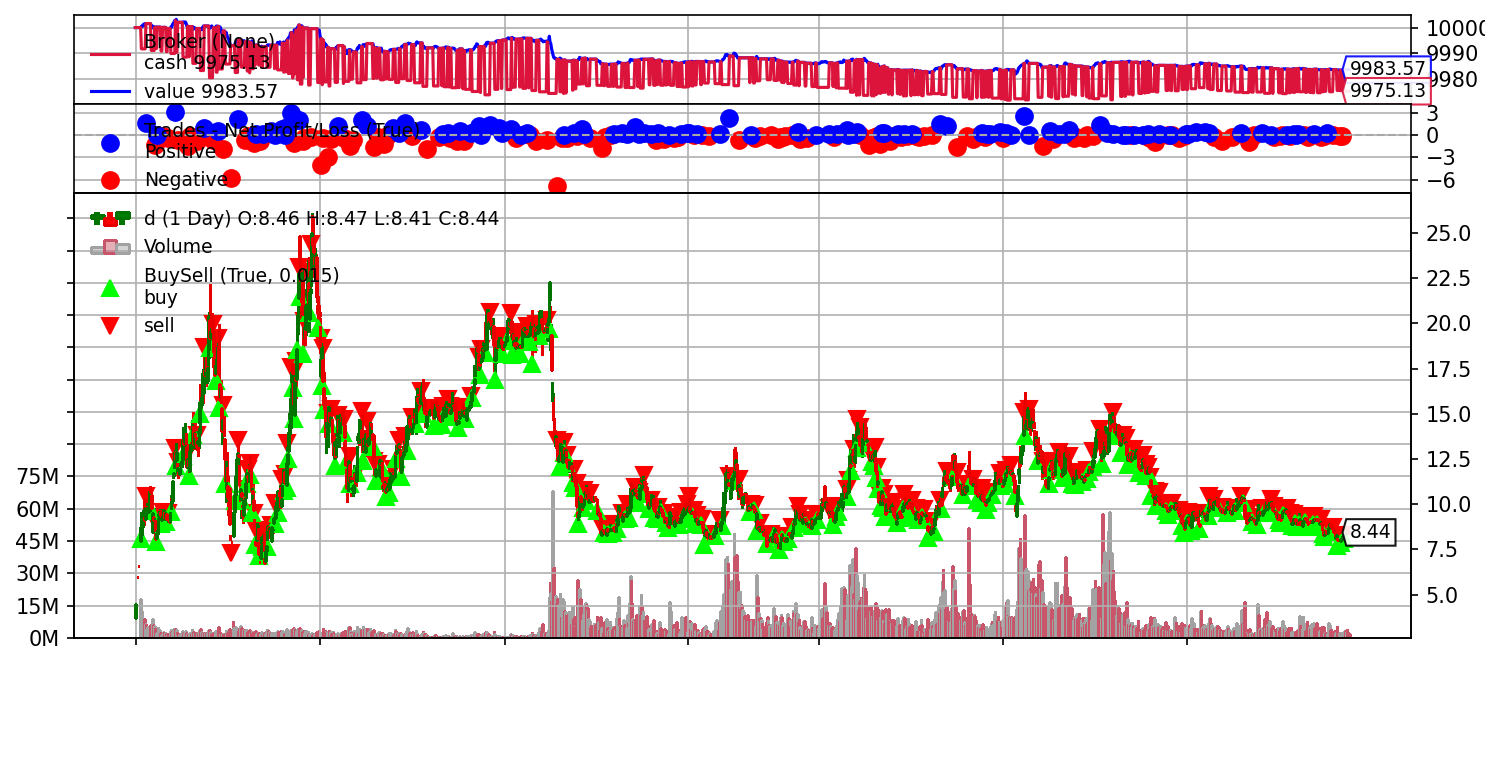

[[<Figure size 640x480 with 4 Axes>]]

In [14]:
cerebro.plot(
#     iplot=True,
#     start=datetime.date(2021, 1, 1),
#     end=datetime.date(2021, 11, 24),
    style='candlestick',
    barup='green',
    bardown='red',
    barupfill=True, 
    bardownfill=False,
)

In [8]:
# start = "2018-01-01"
# end = "2021-07-05"
# name = ["300etf"]
# code = ["510300"]
# backtest = backtest.BackTest(GridStrategy, start, end, code, name, 100000)
# result = backtest.run()
# # backtest.output()
# print(result)

<IPython.core.display.Javascript object>


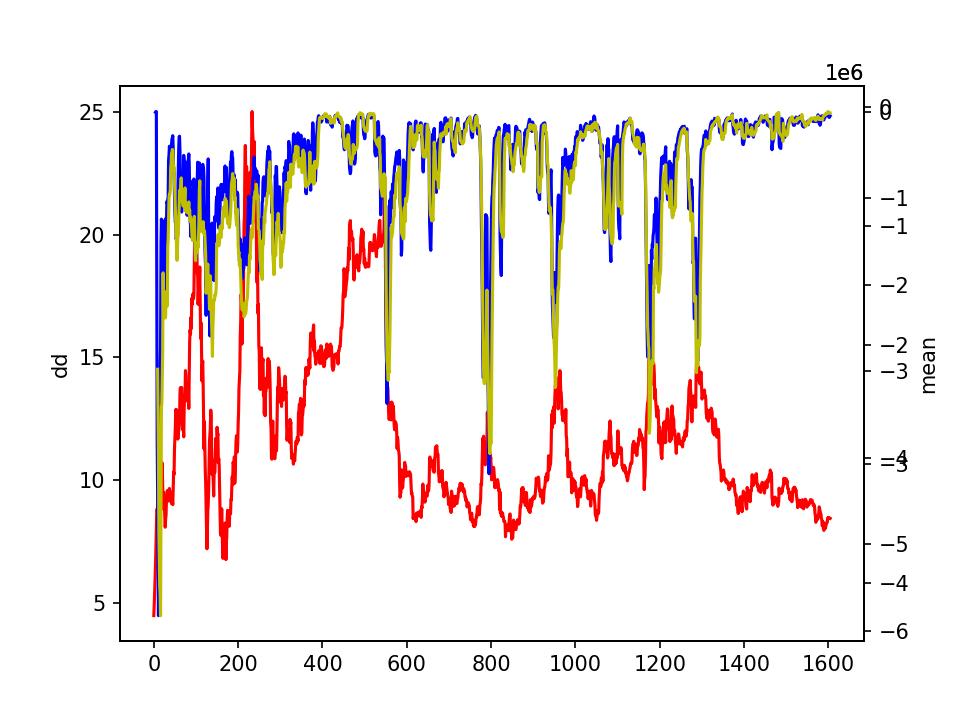

In [20]:
fig, ax1 = plt.subplots()

ax1.set_ylabel('dd')
ax1.plot(df.close.values, c='r')

ax2 = ax1.twinx()

ax2.set_ylabel('mean')
ax2.plot(df.dd.rolling(5).mean().values, c='b')

ax3 = ax1.twinx()

# ax3.set_ylabel('mean 5')
ax3.plot(df.dd.rolling(10).mean().values, c='y')

plt.show()

<IPython.core.display.Javascript object>


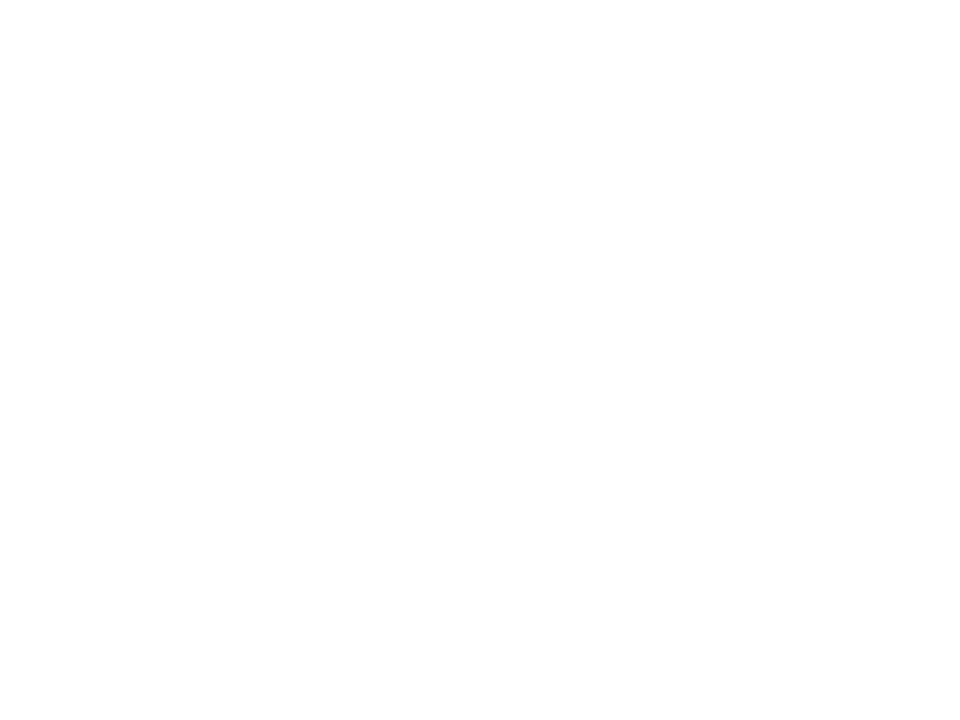

AttributeError: 'numpy.ndarray' object has no attribute 'set_ylabel'

In [19]:
fig, ax1 = plt.subplots(2, 2)

ax1.set_ylabel('dd')
ax1.plot(df.close.values, c='r')

ax2 = ax1.twinx()

ax2.set_ylabel('mean')
ax2.plot(df.dd.rolling(5).mean().values, c='b')

ax3 = ax1.twinx()

# ax3.set_ylabel('mean 5')
ax3.plot(df.dd.rolling(10).mean().values, c='y')

plt.show()